In [1]:
import torch
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from typing import Callable, List
import numpy as np
import pandas as pd
import glob
import pathlib
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
IMG_PATH = "/home/zachcoleman/burnt-ends/data/coco/imgs/val"
IMG_SIZE = (512, 512)

In [3]:
class ImageDataset:
    def __init__(self, img_dir, transforms: List[Callable] = None, ext = "jpg"):
        self.filepaths = glob.glob(str(pathlib.Path(img_dir) / f"*.{ext}"))
        if transforms is None:
            self.transforms = []
        else:
            self.transforms = transforms
    def __len__(self):
        return len(self.filepaths)
    def __getitem__(self, idx):
        img_tens = read_image(self.filepaths[idx], mode=ImageReadMode.RGB)
        # print(img_tens, idx, self.filepaths[idx])
        for t in self.transforms:
            img_tens = t(img_tens)
        return img_tens
    @classmethod
    def plot(cls, x, ax = None):
        if ax is None:
            return plt.imshow(x.permute([1, 2, 0]).numpy())
        else:
            return ax.imshow(x.permute([1, 2, 0]).numpy())

In [4]:
resize = lambda x: torch.nn.functional.interpolate(x.unsqueeze(0), size=IMG_SIZE)[0]
normalize = lambda x: x / 255.

In [5]:
ds = ImageDataset(IMG_PATH, [resize, normalize])

In [6]:
dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=4,
    shuffle=True
)

In [7]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = [
            torch.nn.Conv2d(3, 32, 7, 2, 3),
            torch.nn.Conv2d(32, 64, 5, 2, 2),
            torch.nn.Conv2d(64, 8, 1, 1, "same"),
            torch.nn.ConvTranspose2d(8, 16, 4, 2, 1),
            torch.nn.ConvTranspose2d(16, 32, 4, 2, 1),
            torch.nn.Conv2d(32, 3, 1, 1, "same")
        ]
        self.layers = torch.nn.ModuleList(self.layers)

    def forward(self, inputs):
        x = inputs
        for l in self.layers:
            x = l(x)
        return x


In [8]:
auto_encoder = AutoEncoder()
auto_encoder.to("cuda")
loss_fn = torch.nn.L1Loss()
optim = torch.optim.Adam(auto_encoder.parameters())
iter_data_loader = iter(dataloader)

In [9]:
for i in range(10_000):
    optim.zero_grad()
    X = next(iter_data_loader)
    X = X.to("cuda")
    output = auto_encoder(X)
    loss = loss_fn(output, X)
    if (i+1) % 100 == 0:
        print(f"loss @ {i+1}th step: {loss}")
    loss.backward()
    optim.step()

loss @ 100th step: 0.10544969886541367
loss @ 200th step: 0.0626198947429657
loss @ 300th step: 0.04547629877924919
loss @ 400th step: 0.031811442226171494
loss @ 500th step: 0.06411752104759216
loss @ 600th step: 0.04771948605775833
loss @ 700th step: 0.0440727099776268
loss @ 800th step: 0.040967073291540146
loss @ 900th step: 0.04983142763376236
loss @ 1000th step: 0.035080261528491974
loss @ 1100th step: 0.0296633280813694
loss @ 1200th step: 0.0342780277132988


StopIteration: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


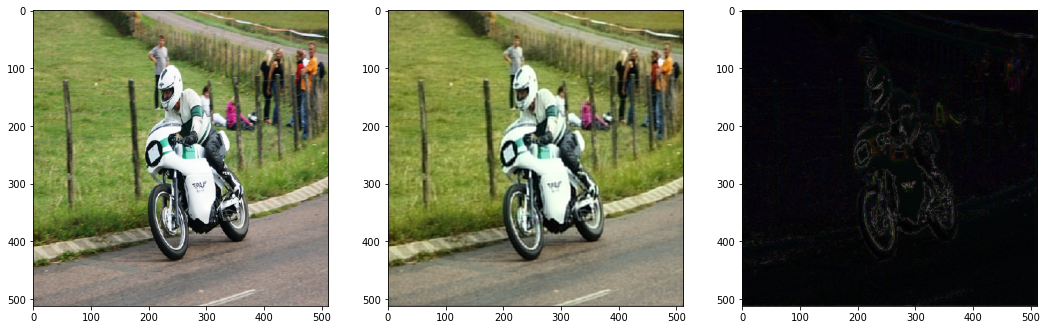

In [18]:
ix = 3
fig, ax = plt.subplots(1, 3, figsize=(18, 12))
ds.plot(ds[ix], ax[0])
with torch.inference_mode():
    tmp = auto_encoder.forward(ds[ix].unsqueeze(0).to("cuda"))[0].cpu()
ds.plot(tmp, ax[1])
ds.plot(torch.abs(tmp - ds[ix]), ax[2])